# ML Homework4
0756021 張逸群

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
%matplotlib inline

## Gaussian Random Number Generator from hw3

In [2]:
def sample_from_uni_normal(mean, var, size=1):
    # using Marsaglia polar method
    U, V = np.random.uniform(-1, 1, size), np.random.uniform(-1, 1, size)
    S = U*U + V*V
    
    # replace S >= 1
    while (S >= 1).any():
        replace_indices = (S >= 1)
        replace_size = replace_indices.sum()
        U[replace_indices], V[replace_indices] = np.random.uniform(-1, 1, replace_size), np.random.uniform(-1, 1, replace_size)
        S[replace_indices] = U[replace_indices]*U[replace_indices] + V[replace_indices]*V[replace_indices]
    
    X = U * np.sqrt( -2. * np.log(S) / S )
    return X * np.sqrt(var) + mean

## 1. Logistic Regression

In [3]:
class LogisticRegressionClassifier:
    def __init__(self):
        self._n_dim = -1
        self._weights = None # (n_dim+1, 1)
        self._used_gd = False
        
    def _logistic(self, X):
        return (1. / (1. + np.exp(-X @ self._weights)))
    
    @staticmethod
    def _append_bias(X):
        X = X.reshape(X.shape[0], -1) # (?, n_dim)
        biased_X = np.ones((X.shape[0], X.shape[1]+1)) # (?, n_dim+1) data+bias
        biased_X[:, :-1] = X
        return biased_X
    
    def predict(self, X, print_report=False, y_true=None):
        X = self._append_bias(X) # (?, n_dim)
        predictions = (self._logistic(X).flatten() > 0.5).astype(np.float32)
        
        if print_report:
            print('{}:\n'.format('Gradient descent:' if self._used_gd else 'Newton\'s method:'))
            print('w:')
            for wi in self._weights.flatten():
                print('{:20.10f}'.format(wi))
            
            if y_true is not None:
                print('\nConfusion Matrix:')
                print('             Predict cluster 1 Predict cluster 2')
                print('Is cluster 1        {}               {}'.format(np.logical_and(predictions == 0, y_true == 0).sum(),
                                                                       np.logical_and(predictions == 1, y_true == 0).sum()))
                print('Is cluster 2        {}               {}'.format(np.logical_and(predictions == 0, y_true == 1).sum(),
                                                                       np.logical_and(predictions == 1, y_true == 1).sum()))
                print()
                print('Sensitivity (Successfully predict cluster 1): {:.5f}'.format(np.logical_and(predictions == 0, y_true == 0).sum() / (y_true==0).sum()))
                print('Sensitivity (Successfully predict cluster 2): {:.5f}'.format(np.logical_and(predictions == 1, y_true == 1).sum() / (y_true==1).sum()))
            print('\n----------------------------------------')
            
        return predictions
    
    def _gd_update(self, X, y, lr=0.5):
        delta = X.T @ (y - self._logistic(X))
        self._weights += lr * delta
        return delta
    
    def _newton_update(self, X, y, lr=0.5):
        # calculate D matrix
        D = np.identity(X.shape[0])
        exw = np.exp(-X @ self._weights)
        # np.fill_diagonal(D, ( exw / np.power(1. + exw, 2))) # this overflows quite often
        np.fill_diagonal(D, 1. / (1. + exw) - 1. / (1. + exw) / (1. + exw))
        
        HJ = X.T @ D @ X
        tangent = X.T @ (y - self._logistic(X))
        
        try:
            delta = np.linalg.inv(HJ) @ tangent
        except np.linalg.LinAlgError:
            # can't do inverse, use gd instead
            delta = tangent
        
        self._weights += lr * delta
        
        return delta

    def fit(self, X, y, max_iter=None, min_delta=None, return_history=False, use_gd=False):
        y = y.reshape((-1, 1))
        X = self._append_bias(X) # (?, n_dim)
        self._n_dim = X.shape[1] # data+bias
        self._weights = np.random.rand(self._n_dim, 1) - 0.5
        self._weights[-1] = 0 # bias == 0
        self._used_gd = use_gd
        
        n_iter = 0
        history = {'weights': list(), 'delta': list()}
        while (max_iter is None or n_iter < max_iter):
            n_iter += 1
            
            if use_gd:
                delta = self._gd_update(X, y)
            else: # newton's method
                delta = self._newton_update(X, y)
            
            history['weights'].append(self._weights)
            history['delta'].append(delta)
            
            if min_delta is not None and (np.abs(delta) < min_delta).all():
                print('{} converged! n_iter = {}'.format('gd' if use_gd else 'newton', n_iter))
                break
            
        history['weights'] = np.array(history['weights'])
        history['delta'] = np.array(history['delta'])
        if return_history:
            return self, history
        return self

In [4]:
def generate_data(number_data, mean_X1, var_X1, mean_y1, var_y1, mean_X2, var_X2, mean_y2, var_y2):
    X1 = np.stack([sample_from_uni_normal(mean_X1, var_X1, size=number_data), sample_from_uni_normal(mean_y1, var_y1, size=number_data)], axis=1)
    X2 = np.stack([sample_from_uni_normal(mean_X2, var_X2, size=number_data), sample_from_uni_normal(mean_y2, var_y2, size=number_data)], axis=1)
    X = np.append(X1, X2, axis=0)
    y = np.array([0]*number_data + [1]*number_data)
    return X, y

In [5]:
def plot_result(X, y):
    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(30, 5))

    axes[0].set_title('Ground Truth')
    axes[0].scatter(X[:, 0], X[:, 1], c=y)

    axes[1].set_title('Gradient Descent')
    pred = LogisticRegressionClassifier().fit(X, y, min_delta=1e-3, max_iter=10000, use_gd=True).predict(X, print_report=True, y_true=y)
    axes[1].scatter(X[:, 0], X[:, 1], c=pred)

    axes[2].set_title('Newton\'s Method')
    pred = LogisticRegressionClassifier().fit(X, y, min_delta=1e-3, max_iter=10000, use_gd=False).predict(X, print_report=True, y_true=y)
    axes[2].scatter(X[:, 0], X[:, 1], c=pred)

### Result

gd converged! n_iter = 11
Gradient descent::

w:
        7.9086098307
       26.2520431988
     -125.7726618096

Confusion Matrix:
             Predict cluster 1 Predict cluster 2
Is cluster 1        50               0
Is cluster 2        0               50

Sensitivity (Successfully predict cluster 1): 1.00000
Sensitivity (Successfully predict cluster 2): 1.00000

----------------------------------------
newton converged! n_iter = 148
Newton's method::

w:
        4.5063198819
       24.2424941046
     -163.5486565323

Confusion Matrix:
             Predict cluster 1 Predict cluster 2
Is cluster 1        50               0
Is cluster 2        0               50

Sensitivity (Successfully predict cluster 1): 1.00000
Sensitivity (Successfully predict cluster 2): 1.00000

----------------------------------------


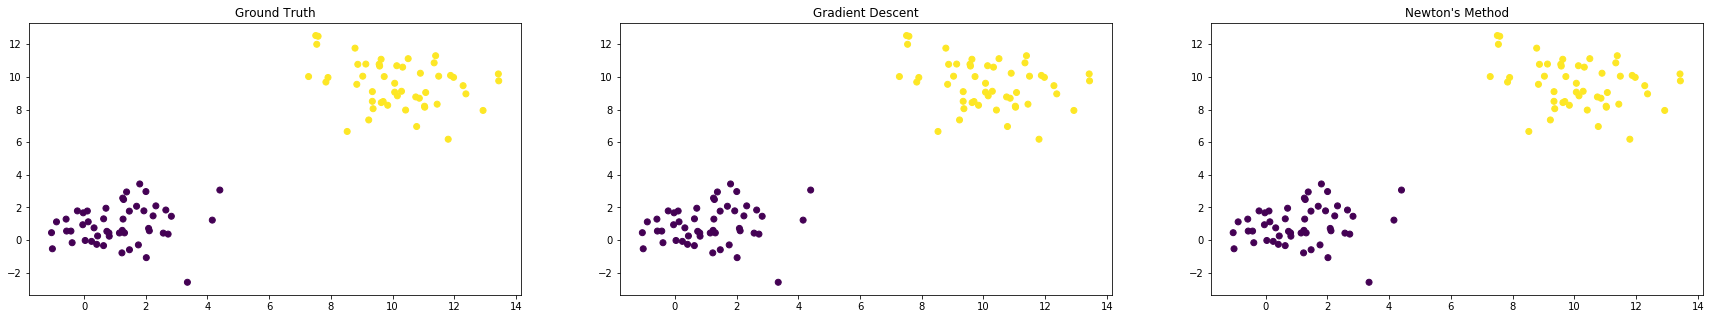

In [6]:
number_data = 50
mean_X1, var_X1, mean_y1, var_y1 = 1, 2, 1, 2
mean_X2, var_X2, mean_y2, var_y2 = 10, 2, 10, 2

X, y = generate_data(number_data, mean_X1, var_X1, mean_y1, var_y1, mean_X2, var_X2, mean_y2, var_y2)
plot_result(X, y)

Gradient descent::

w:
        7.9269309749
        6.9751769682
      -85.4264339964

Confusion Matrix:
             Predict cluster 1 Predict cluster 2
Is cluster 1        50               0
Is cluster 2        45               5

Sensitivity (Successfully predict cluster 1): 1.00000
Sensitivity (Successfully predict cluster 2): 0.10000

----------------------------------------
newton converged! n_iter = 14
Newton's method::

w:
        0.6959388648
        0.5349873318
       -2.4382676241

Confusion Matrix:
             Predict cluster 1 Predict cluster 2
Is cluster 1        41               9
Is cluster 2        11               39

Sensitivity (Successfully predict cluster 1): 0.82000
Sensitivity (Successfully predict cluster 2): 0.78000

----------------------------------------


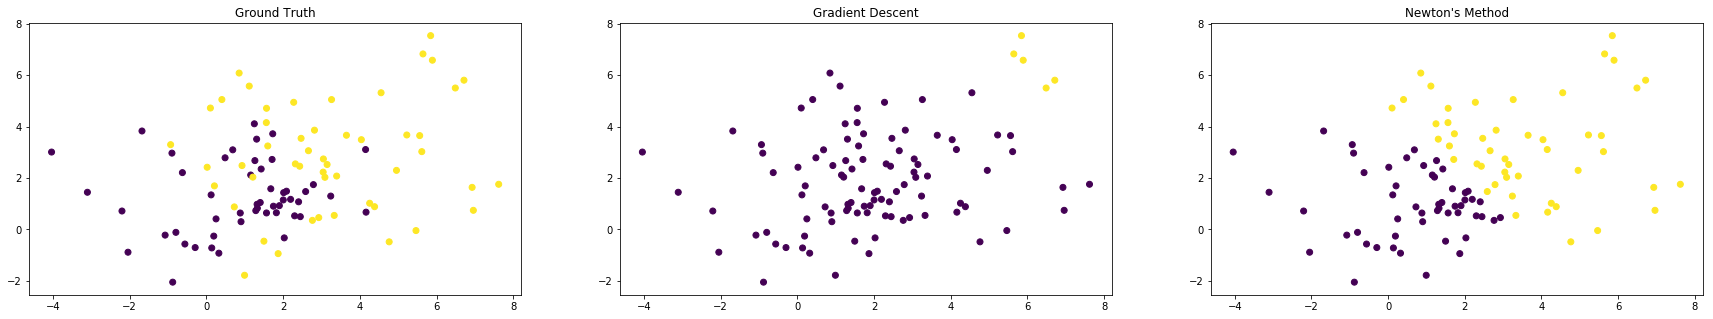

In [7]:
number_data = 50
mean_X1, var_X1, mean_y1, var_y1 = 1, 2, 1, 2
mean_X2, var_X2, mean_y2, var_y2 = 3, 4, 3, 4

X, y = generate_data(number_data, mean_X1, var_X1, mean_y1, var_y1, mean_X2, var_X2, mean_y2, var_y2)
plot_result(X, y)

## MNIST Reader from hw2

In [8]:
class MNISTReader:
    def __init__(self):
        pass
    
    @staticmethod
    def read_images(filename):
        with open(filename, 'rb') as f:
            # check magic number
            if int.from_bytes(f.read(4), byteorder='big', signed=True) != 0x803:
                raise IOError('File Magic Number Error')

            number_images = int.from_bytes(f.read(4), byteorder='big', signed=True)
            number_rows = int.from_bytes(f.read(4), byteorder='big', signed=True)
            number_columns = int.from_bytes(f.read(4), byteorder='big', signed=True)

            images_bytes = f.read()

        images = np.frombuffer(images_bytes, dtype=np.uint8)
        images = images.reshape(number_images, number_rows, number_columns)
        return images
    
    @staticmethod
    def read_labels(filename):
        with open(filename, 'rb') as f:
            # check magic number
            if int.from_bytes(f.read(4), byteorder='big', signed=True) != 0x801:
                raise IOError('File Magic Number Error')

            number_items = int.from_bytes(f.read(4), byteorder='big', signed=True)
            labels_bytes = f.read()

        labels = np.frombuffer(labels_bytes, dtype=np.uint8)
        return labels

In [9]:
X_train = MNISTReader.read_images('./train-images-idx3-ubyte')
y_train = MNISTReader.read_labels('./train-labels-idx1-ubyte')
X_test = MNISTReader.read_images('./t10k-images-idx3-ubyte')
y_test = MNISTReader.read_labels('./t10k-labels-idx1-ubyte')

## 2. EM Algorithm

* Expectation step
\begin{equation*}
z_{n, k} \leftarrow \frac{\pi_k \prod_{i = 1}^D \mu_{k, i}^{x_{n, i}} (1 - \mu_{k, i})^{1 - x_{n, i}} }{\sum_{m = 1}^K \pi_m \prod_{i = 1}^D \mu_{m, i}^{x_{n, i}} (1 - \mu_{m, i})^{1 - x_{n, i}}}.
\end{equation*}

* Maximization step
\begin{equation*}
\mathbf{\mu_m} \leftarrow \mathbf{\bar{x}_m},  
\end{equation*}

\begin{equation*}
\pi_m \leftarrow \frac{N_m}{N},  
\end{equation*}

where
\begin{equation*}
\mathbf{\bar{x}_m} = \frac{1}{N_m} \sum_{n = 1}^N z_{n, m} \mathbf{x_n}  
\end{equation*}
\begin{equation*}
N_m = \sum_{n = 1}^N z_{n, m}  
\end{equation*}

In [10]:
from numba import jit, prange

@jit(nopython=True, parallel=True)
def speedup_E_step(X, n_groups, z, pi, mu):
    # calculate z
    for index_sample in prange(X.shape[0]):
        for index_group in prange(n_groups):
            # self._z[index_sample, index_group] = self._pi[index_group] *\
            #                                         np.exp( (X[index_sample] * np.log(self._mu[:, index_group]) +\
            #                                                   (1. - X[index_sample]) * np.log(1. - self._mu[:, index_group])).sum())

            # to prevent underflow
            z[index_sample, index_group] = np.log(pi[index_group]) +\
                                                (X[index_sample] * np.log(mu[:, index_group]) +\
                                                    (1. - X[index_sample]) * np.log(1. - mu[:, index_group])).sum()

        # normalize
        # self._z[index_sample, :] /= self._z[index_sample, :].sum()

        # to prevent underflow
        z[index_sample, :] -= z[index_sample, :].max()
        z[index_sample, :] = np.exp(z[index_sample, :]) / np.exp(z[index_sample, :]).sum()
        
        for index_group in prange(n_groups):
            if z[index_sample, index_group] < 1e-5:
                z[index_sample, index_group] = 0
    return z, pi, mu

@jit(nopython=True, parallel=True)
def speedup_M_step(X, n_groups, z, pi, mu):
    for index_group in prange(n_groups):
        zi_sum = z[:, index_group].sum()

        pi[index_group] = zi_sum / X.shape[0]
        pi[pi < 1e-13] = 1e-13 # prevent zero
        mu[:, index_group] = 0

        for index_sample in prange(X.shape[0]):
            mu[:, index_group] += z[index_sample, index_group] * X[index_sample]
        mu[:, index_group] = (mu[:, index_group] + 1e-13) / (zi_sum + 1e-13 * X.shape[1])
    return z, pi, mu

@jit(nopython=True, parallel=True)
def speedup_likelihood(X, sample_indices, n_groups, z, pi, mu):
    
    likelihood = 0.
    for n in sample_indices:
        for k in range(n_groups):
            likelihood += z[n, k] * (np.log(pi[k]) + (X[n]*np.log(mu[:, k])).sum() + ( (1. - X[n])*np.log(1 - mu[:, k])).sum())
    return likelihood

class EM:
    def __init__(self):
        self._z = None
        self._pi = None
        self._mu = None
        self._n_groups = None
        
    def _bining(self, X):
        X = X.reshape(X.shape[0], -1)
        X = (X > 127).astype(np.float32)
        return X
    
    def _E_step(self, X):
        # update _z
        self._z, self._pi, self._mu = speedup_E_step(X, self._n_groups, self._z, self._pi, self._mu)
        
    def _M_step(self, X):
        # update _pi, _mu
        self._z, self._pi, self._mu = speedup_M_step(X, self._n_groups, self._z, self._pi, self._mu)
        
    def _log_likelihood(self, X):
        return speedup_likelihood(X, np.random.randint(X.shape[0], size=5000), self._n_groups, self._z, self._pi, self._mu)
    
    @staticmethod
    def find_label_mapping(pred, true):
        mapping = np.zeros((10)) -1
        for i in range(10):
            unique, counts = np.unique(y_train[np.where(pred == i)], return_counts=True)
            if unique.shape[0] > 0:
                mapping[i] = unique[counts.argmax()]
        return mapping
    
    def print_cm(self, pred, true, converge_iter):
        mapping = self.find_label_mapping(pred, true)
        mapped_pred = mapping[pred]
        for i in range(10):
            print()
            print('Confusion Matrix {}:'.format(i))
            print('                Predict number {} Predict not number {}'.format(i, i))
            print('Is number {}          {}               {}'.format(i, np.logical_and(mapped_pred == i, true == i).sum(),
                                                                           np.logical_and(mapped_pred != i, true == i).sum()))
            print('Isn\'t number {}          {}               {}'.format(i, np.logical_and(mapped_pred == i, true != i).sum(),
                                                                           np.logical_and(mapped_pred != i, true != i).sum()))
            print()
            print('Sensitivity (Successfully predict number {})    : {:.5f}'.format(i, np.logical_and(mapped_pred == i, true == i).sum() / (true==i).sum()))
            print('Specificity (Successfully predict not number {}): {:.5f}'.format(i, np.logical_and(mapped_pred != i, true != i).sum() / (true!=i).sum()))
            print()
            print('------------------------------------------------------------')

        print()
        print('Total iteration to converge: {}'.format(converge_iter))
        print('Total error rate: {:.10f}'.format(1. - (mapped_pred == true).sum() / true.shape[0]))
    
    def plot_imagination(self, mapping):
        fig, axes = plt.subplots(ncols=10, nrows=1, sharex=True, sharey=True, figsize=(30, 10))
        for (i, mi), ax in zip(enumerate(mapping.argsort()), axes.flatten()):
            ax.imshow(self._mu[:, mi].reshape(28, 28))
            ax.set_title('pred[{}] -> {}'.format(mi, mapping[mi]))
        plt.show()
    
    def fit_transform(self, X, y_true=None, n_groups=10, max_iter=None, min_delta=None):
        # do bining
        X = self._bining(X)
        
        # initial
        self._z = np.zeros((X.shape[0], n_groups))
        self._pi = np.random.rand(n_groups)
        self._pi /= self._pi.sum() # sum up to one
        self._mu = np.random.rand(X.shape[1], n_groups)
        self._n_groups = n_groups
        
        n_iter = 0
        last_mu = self._mu.copy()
        last_log_likelihood = self._log_likelihood(X)
        while max_iter is None or n_iter < max_iter:
            n_iter += 1
            print('iteration:', n_iter)
            
            # E step
            self._E_step(X)
                
            # M step
            self._M_step(X)
            
            if y_true is not None and n_iter < 4:
                self.plot_imagination(self.find_label_mapping(np.argmax(self._z, axis=1), y_true))
                
            log_likelihood = self._log_likelihood(X)
            log_likelihood_diff = log_likelihood - last_log_likelihood
            last_log_likelihood = log_likelihood
            print('\tLikelihood:', log_likelihood, 'Difference:', log_likelihood_diff)
            
            if min_delta is not None and (np.abs(last_mu - self._mu) < min_delta).all():
                print('converged!')
                break
                
            last_mu = self._mu.copy()
        
        self.plot_imagination(self.find_label_mapping(np.argmax(self._z, axis=1), y_true))
        return np.argmax(self._z, axis=1), n_iter

iteration: 1


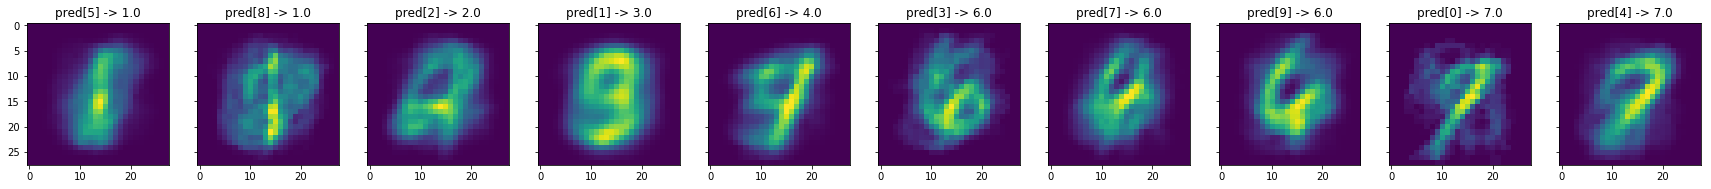

	Likelihood: -997427.9731566934 Difference: -997427.9731566934
iteration: 2


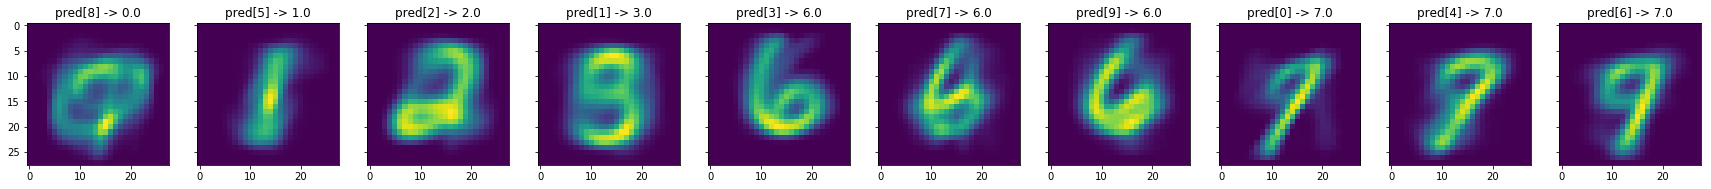

	Likelihood: -909474.5790480095 Difference: 87953.39410868392
iteration: 3


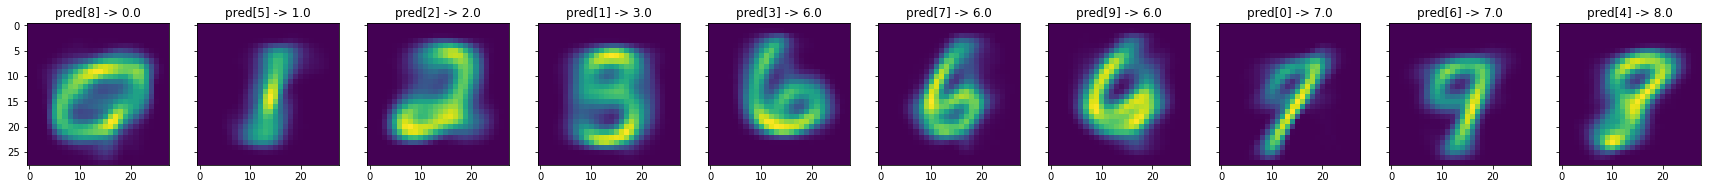

	Likelihood: -879778.4027628137 Difference: 29696.176285195746
iteration: 4
	Likelihood: -860932.5906826154 Difference: 18845.812080198317
iteration: 5
	Likelihood: -844721.3799131776 Difference: 16211.210769437836
iteration: 6
	Likelihood: -835099.8891058305 Difference: 9621.490807347116
iteration: 7
	Likelihood: -831123.1710775238 Difference: 3976.718028306612
iteration: 8
	Likelihood: -831830.7686869903 Difference: -707.5976094664074
iteration: 9
	Likelihood: -827120.3645470766 Difference: 4710.404139913619
iteration: 10
	Likelihood: -826223.1429303841 Difference: 897.2216166924918
iteration: 11
	Likelihood: -827392.7528503557 Difference: -1169.6099199715536
iteration: 12
	Likelihood: -823109.5234434477 Difference: 4283.229406908038
iteration: 13
	Likelihood: -824462.0552454271 Difference: -1352.5318019794067
iteration: 14
	Likelihood: -828596.9210322303 Difference: -4134.865786803188
iteration: 15
	Likelihood: -825855.5027863866 Difference: 2741.4182458436117
iteration: 16
	Likelih

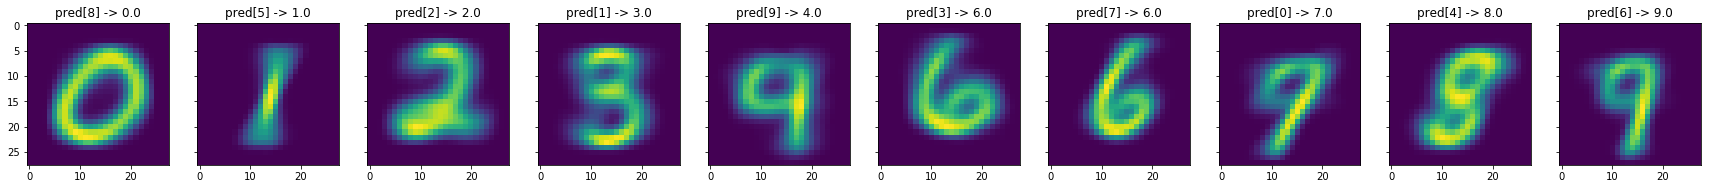

In [11]:
em = EM()
groups, converge_iter = em.fit_transform(X_train, y_train, max_iter=30, min_delta=1e-3)

In [12]:
em.print_cm(groups, y_train, converge_iter)


Confusion Matrix 0:
                Predict number 0 Predict not number 0
Is number 0          4707               1216
Isn't number 0          302               53775

Sensitivity (Successfully predict number 0)    : 0.79470
Specificity (Successfully predict not number 0): 0.99442

------------------------------------------------------------

Confusion Matrix 1:
                Predict number 1 Predict not number 1
Is number 1          6178               564
Isn't number 1          949               52309

Sensitivity (Successfully predict number 1)    : 0.91635
Specificity (Successfully predict not number 1): 0.98218

------------------------------------------------------------

Confusion Matrix 2:
                Predict number 2 Predict not number 2
Is number 2          4468               1490
Isn't number 2          452               53590

Sensitivity (Successfully predict number 2)    : 0.74992
Specificity (Successfully predict not number 2): 0.99164

---------------------------